# Analyse Fit results

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : August 26th 2023
- last update : August 26th 2023


In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms


%matplotlib inline

import h5py
import seaborn as sns
import copy
from collections import OrderedDict

In [2]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [4]:
import time
from datetime import datetime,date
from astropy.time import Time
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser

In [5]:
DATE = "20230117"
FILTERTYPE = "empty~holo4_003"
spectractormode = "psf2dffm"
ext = "rebin2"   # run BPS by removing ACQ
FLAG_POLAR = True

In [6]:
if FLAG_POLAR: 
    input_filename_h5 = f"dataout/fitatmparam_single_night-HD185975-{DATE}-{FILTERTYPE}-{spectractormode}-{ext}-oga.hdf5"
else:
    input_filename_h5 = f"dataout/fitatmparam_single_night-alltargets-{DATE}-{FILTERTYPE}-{spectractormode}-{ext}-oga.hdf5"

In [7]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [8]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2023-08-26 17:47:11,711 iMac-de-Sylvie.local __main__[7252] INFO LA time:08:47:11
2023-08-26 17:47:11,720 iMac-de-Sylvie.local __main__[7252] INFO NY time:11:47:11
2023-08-26 17:47:11,722 iMac-de-Sylvie.local __main__[7252] INFO London time:16:47:11
2023-08-26 17:47:11,724 iMac-de-Sylvie.local __main__[7252] INFO Paris time:17:47:11
2023-08-26 17:47:11,725 iMac-de-Sylvie.local __main__[7252] INFO ************************ START *********************


In [9]:
fn = "fitatmparam_single_night-HD185975-2023-01-17-empty~holo4_003-psf2dffm-rebin2-oga.hdf5"

In [10]:
hf =  h5py.File( input_filename_h5, 'r') 
list_of_keys = list(hf.keys())
print(list_of_keys)

['obs_sequence', 'params', 'params_indexes']


In [11]:
def decodeh5file(hf):
    """
    """
    
    list_of_keys = list(hf.keys())
    for key_sel in list_of_keys:
        
        if key_sel ==  'params':
            group = hf.get(key_sel)
            data_param_names =  np.array(group.get("param_names")).flatten()
            data_param_values =  np.array(group.get("param_values"))
            data_param_cov =  np.array(group.get("param_cov"))
            
        if key_sel == 'obs_sequence':
            group = hf.get(key_sel)
            data_numbers = np.array(group.get("numbers"))
            data_datetime = np.array(group.get("datetime")).flatten()
        
    return   data_param_names, data_param_values ,  data_param_cov , data_numbers,data_datetime 

In [12]:
param_names, param_values, param_cov, obs_numbers,obs_datetime = decodeh5file(hf)

In [13]:
hf.close()

In [14]:
param_names

array([b'pwv', b'oz', b'tau', b'beta', b'grey_0', b'grey_1', b'grey_2',
       b'grey_3', b'grey_4', b'grey_5', b'grey_6', b'grey_7', b'grey_8',
       b'grey_9', b'grey_10', b'grey_11', b'grey_12', b'grey_13',
       b'grey_14', b'grey_15', b'grey_16', b'grey_17'], dtype='|S10')

In [15]:
obs_datetime

array([b'2023-01-18T02:33:44.', b'2023-01-18T02:34:27.',
       b'2023-01-18T03:05:13.', b'2023-01-18T03:48:30.',
       b'2023-01-18T03:49:13.', b'2023-01-18T04:27:59.',
       b'2023-01-18T04:28:42.', b'2023-01-18T05:02:33.',
       b'2023-01-18T05:03:16.', b'2023-01-18T05:51:01.',
       b'2023-01-18T05:51:44.', b'2023-01-18T06:27:07.',
       b'2023-01-18T06:27:50.', b'2023-01-18T06:59:45.',
       b'2023-01-18T07:00:28.', b'2023-01-18T07:40:35.',
       b'2023-01-18T08:48:10.', b'2023-01-18T08:48:52.'], dtype='|S20')

In [16]:
all_datetime = [ Time(str_time).to_datetime() for str_time in obs_datetime ]

In [17]:
N = len(all_datetime)
popt = param_values
pcov = param_cov
numbers = obs_numbers

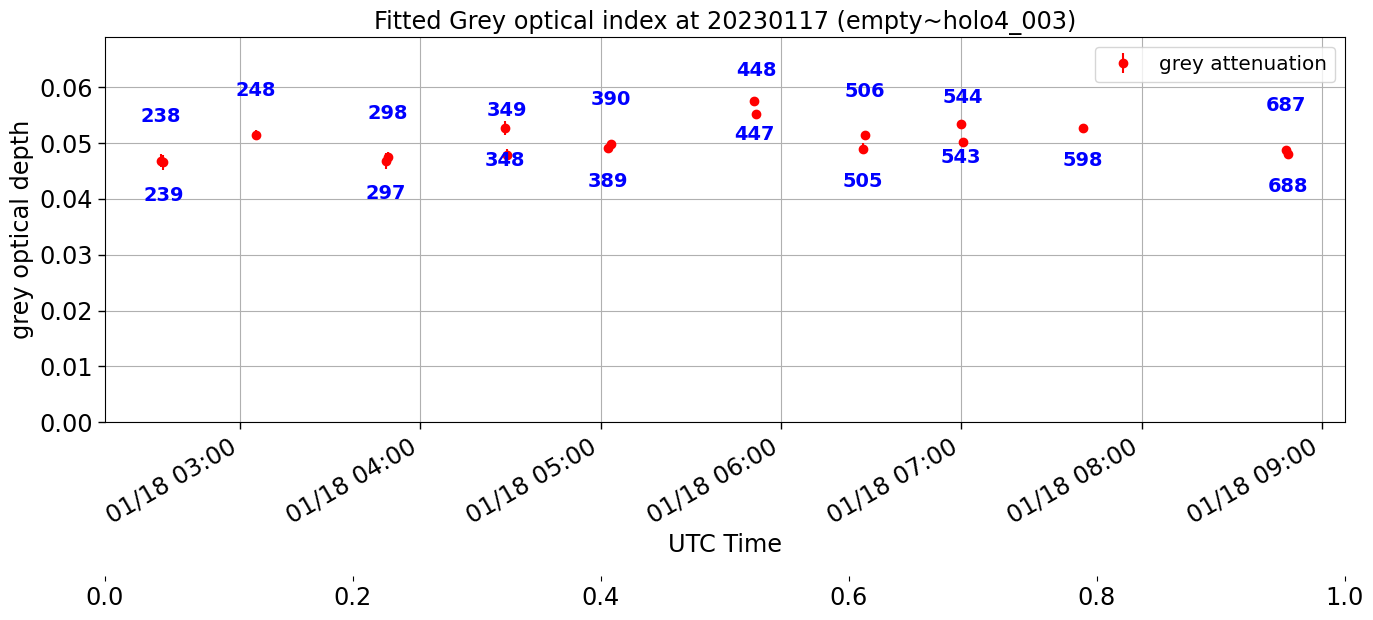

In [19]:
greys = popt[4:4+N]
ngreys = len(greys)
greys_err = np.sqrt(np.diag(pcov))[4:4+N]



fig =plt.figure(figsize=(16,5))


# First axis : grey attenuation vs UTC date
#===========================================
ax = fig.add_subplot(1,1,1)
ax.errorbar(all_datetime ,greys,yerr=greys_err,fmt='o',color="r",label="grey attenuation")
fmt = '%m/%d %H:%M'
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(fmt))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.tick_params(which='major', width=1.00, length=5)
ax.tick_params(which='minor', width=0.75, length=2.5)
ax.grid(True)
#plt.gcf().autofmt_xdate()  # orient date labels at a slant
# slant for this axis
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax.set_xlabel("UTC Time")


#ax.errorbar(np.arange(naer),aer,yerr=aer_err,fmt='o',color="b",label="aer attenuation")


title=f"Fitted Grey optical index at {DATE} ({FILTERTYPE})"
ax.set_title(title)

ax.set_ylabel("grey optical depth")
ax.set_ylim(0.,np.max(greys)*1.2)
ax.legend()

ymin,ymax  = ax.get_ylim()
yscale = ymax-ymin
y_shift = yscale/10.

for index in range(N):
    textstr= str(numbers[index])
    if index%2 == 0:
        dy = y_shift
    else:
        dy = -y_shift
            
    ax.text(all_datetime[index], greys[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color="b" )

# Second axis shown as an example for ticks and label position shifing from 
# https://github.com/sylvielsstfr/AuxtelStarAlt/blob/main/notebooks/2023-09-12/ObservationOfVisibleCalspecList.ipynb
# ================================

# should plot something like the relative time from the beginning for the ax2-X axis

ax2 = ax.twiny()
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
offset = -0.4
ax2.spines["bottom"].set_position(("axes", offset))

ax2.set_frame_on(True)
ax2.patch.set_visible(False) # mandatory
for sp in ax2.spines.values():
    sp.set_visible(False)